# Trace Analysis Examples

## Tasks Latencies

This notebook shows the features provided for task latency profiling. It will be necessary to collect the following events:
 
Details on idle states profiling ar given in **Latency DataFrames and Latency Plots ** below.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2017-02-17 19:51:33,920 INFO    : root         : Using LISA logging configuration:
2017-02-17 19:51:33,922 INFO    : root         :   /data/Code/lisa/logging.conf


In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support for workload generation
from wlgen import RTA, Ramp

# Support for trace analysis
from trace import Trace

# Support for plotting
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import trappy

## Target Configuration
The target configuration is used to describe and configure your test environment.
You can find more details in **examples/utils/testenv_example.ipynb**.

In [3]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"    : 'linux',
    "board"       : 'juno',
    "host"        : '192.168.0.1',
    "password"    : 'juno',

    # Folder where all the results will be collected
    "results_dir" : "TraceAnalysis_TaskLatencies",

    # Define devlib modules to load
    "modules" : ['cpufreq'],
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
        ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],
    
    # Comment this line to calibrate RTApp in your own platform
    # "rtapp-calib" :  {"0": 360, "1": 142, "2": 138, "3": 352, "4": 352, "5": 353},
}

In [4]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

2017-02-17 19:51:34,465 INFO    : TestEnv      : Using base path: /data/Code/lisa
2017-02-17 19:51:34,466 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-02-17 19:51:34,467 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq']
2017-02-17 19:51:34,468 INFO    : TestEnv      : Connecting linux target:
2017-02-17 19:51:34,469 INFO    : TestEnv      :   username : root
2017-02-17 19:51:34,470 INFO    : TestEnv      :       host : 192.168.0.1
2017-02-17 19:51:34,471 INFO    : TestEnv      :   password : juno
2017-02-17 19:51:34,472 INFO    : TestEnv      : Connection settings:
2017-02-17 19:51:34,473 INFO    : TestEnv      :    {'username': 'root', 'host': '192.168.0.1', 'password': 'juno'}
2017-02-17 19:51:38,957 INFO    : TestEnv      : Initializing target workdir:
2017-02-17 19:51:38,959 INFO    : TestEnv      :    /root/devlib-target
2017-02-17 19:51:41,908 INFO    : TestEnv      : Topology:
2017-02-17 19:51:41,910 INFO    : TestEnv      :    [[0,

## Workload Configuration and Execution

Detailed information on RTApp can be found in **examples/wlgen/rtapp_example.ipynb**.

In [5]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

2017-02-17 19:51:44,484 INFO    : Workload     : Setup new workload ramp
2017-02-17 19:51:44,798 INFO    : Workload     : Workload duration defined by longest task
2017-02-17 19:51:44,800 INFO    : Workload     : Default policy: SCHED_OTHER
2017-02-17 19:51:44,801 INFO    : Workload     : ------------------------
2017-02-17 19:51:44,803 INFO    : Workload     : task [ramp], sched: using default policy
2017-02-17 19:51:44,804 INFO    : Workload     :  | calibration CPU: 1
2017-02-17 19:51:44,806 INFO    : Workload     :  | loops count: 1
2017-02-17 19:51:44,808 INFO    : Workload     : + phase_000001: duration 0.500000 [s] (5 loops)
2017-02-17 19:51:44,809 INFO    : Workload     : |  period   100000 [us], duty_cycle  60 %
2017-02-17 19:51:44,811 INFO    : Workload     : |  run_time  60000 [us], sleep_time  40000 [us]
2017-02-17 19:51:44,812 INFO    : Workload     : + phase_000002: duration 0.500000 [s] (5 loops)
2017-02-17 19:51:44,813 INFO    : Workload     : |  period   100000 [us], d

## Parse Trace and Profiling Data

In [7]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

2017-02-17 19:51:59,998 INFO    : root         : Content of the output folder /data/Code/lisa/results/TraceAnalysis_TaskLatencies


/data/Code/lisa/results/TraceAnalysis_TaskLatencies
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── task_activations_5019_5019__ramp,_rt-app.png
├── task_activations_5083_5083__ramp,_rt-app.png
├── task_latencies_5019_5019__ramp,_rt-app.png
├── task_latencies_5083_5083__ramp,_rt-app.png
├── task_runtimes_5019_5019__ramp,_rt-app.png
├── task_runtimes_5083_5083__ramp,_rt-app.png
├── trace.dat
├── trace.raw.txt
└── trace.txt

0 directories, 13 files


In [8]:
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

2017-02-17 19:52:00,120 INFO    : root         : LITTLE cluster max capacity: 447


In [9]:
trace_file = os.path.join(res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

## Trace visualization

In [10]:
trappy.plotter.plot_trace(trace.ftrace)

# Latency Analysis

## Latency DataFrames

In [11]:
print trace.data_frame.latency_df.__doc__


        DataFrame of task's wakeup/suspend events

        The returned DataFrame has these columns
        - Time: the time an event related to this task happened
        - target_cpu: the CPU where the task has been scheduled
                      reported only for wakeup events
        - curr_state: the current task state:
            A letter which corresponds to the standard events reported by the
            prev_state field of a sched_switch event.
            Only exception is 'A', which is used to represent active tasks,
            i.e. tasks RUNNING on a CPU
        - next_state: the next status for the task
        - t_start: the time when the current status started, it matches Time
        - t_delta: the interval of time after witch the task will switch to the
                   next_state

        :param task: the task to report wakeup latencies for
        :type task: int or str
        


In [12]:
# Report full set of task status informations available from the trace
trace.data_frame.latency_df('ramp').head()

,target_cpu,__cpu,curr_state,next_state,t_start,t_delta
Time,,,,,,
1.778588,NaN,1.0,A,R,1.778588,0.000433
1.779021,NaN,1.0,R,A,1.779021,0.000135
1.779156,NaN,1.0,A,R,1.779156,0.715133
2.494289,NaN,1.0,R,A,2.494289,0.000040
2.494329,NaN,1.0,A,R,2.494329,0.001559


In [13]:
# Report information on sched_switch events
df = trace.data_frame.trace_event('sched_switch')
df.head()

,__comm,__cpu,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,
0.000013,trace-cmd,1,5137,sudo,5136,120,trace-cmd,5137,120,64
0.001866,sudo,1,5136,swapper/1,0,120,sudo,5136,120,64
0.001998,<idle>,0,0,sh,5096,120,swapper/0,0,120,0
0.002457,sh,0,5096,kworker/u12:1,4563,120,sh,5096,120,4096
0.002526,kworker/u12:1,0,4563,sshd,4428,120,kworker/u12:1,4563,120,1


In [14]:
print trace.data_frame.latency_wakeup_df.__doc__


        DataFrame of task's wakeup latencies

        The returned DataFrame has these columns:
        - Time: the time the task wakeups
        - wakeup_latency: the time the task waited before getting a CPU

        :param task: the task to report wakeup latencies for
        :type task: int or str
        


In [15]:
# Report WAKEUP events and their duration
trace.data_frame.latency_wakeup_df('ramp').head()

,wakeup_latency
Time,
2.578911,0.000244
2.678908,0.000022
2.778907,0.000020
2.878907,0.000021
2.978903,0.000021


In [16]:
print trace.data_frame.latency_preemption_df.__doc__


        DataFrame of task's preemption latencies

        The returned DataFrame has these columns:
        - Time: the time the has been preempted
        - preemption_latency: the time the task waited before getting again a CPU

        :param task: the task to report wakeup latencies for
        :type task: int or str
        


In [17]:
# Report PREEMPTION events and their duration
trace.data_frame.latency_preemption_df('ramp').head()

,preempt_latency
Time,
1.779021,0.000135
2.494289,0.000040
2.495888,0.000014
2.496282,0.000009
2.506273,0.000014


## Latency Plots

In [18]:
print trace.analysis.latency.plotLatency.__doc__


        Generate a set of plots to report the WAKEUP and PREEMPT latencies the
        specified task has been subject to. A WAKEUP latencies is the time from
        when a task becomes RUNNABLE till the first time it gets a CPU.
        A PREEMPT latencies is the time from when a RUNNABLE task is suspended
        because of the CPU is assigned to another task till when the task
        enters the CPU again.

        :param task: the task to report latencies for
        :type task: int or list(str)

        :param kind: the kind of latencies to report (WAKEUP and/or PREEMPT")
        :type kind: str

        :param tag: a string to add to the plot title
        :type tag: str

        :param threshold_ms: the minimum acceptable [ms] value to report
                             graphically in the generated plots
        :type threshold_ms: int or float
        


2017-02-17 19:52:01,228 INFO    : Analysis     : Found:    38 WAKEUP latencies
2017-02-17 19:52:01,265 INFO    : Analysis     : Found:    14 PREEMPT latencies
2017-02-17 19:52:01,267 INFO    : Analysis     : Total:    52 latency events
2017-02-17 19:52:01,269 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold
2017-02-17 19:52:01,399 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!


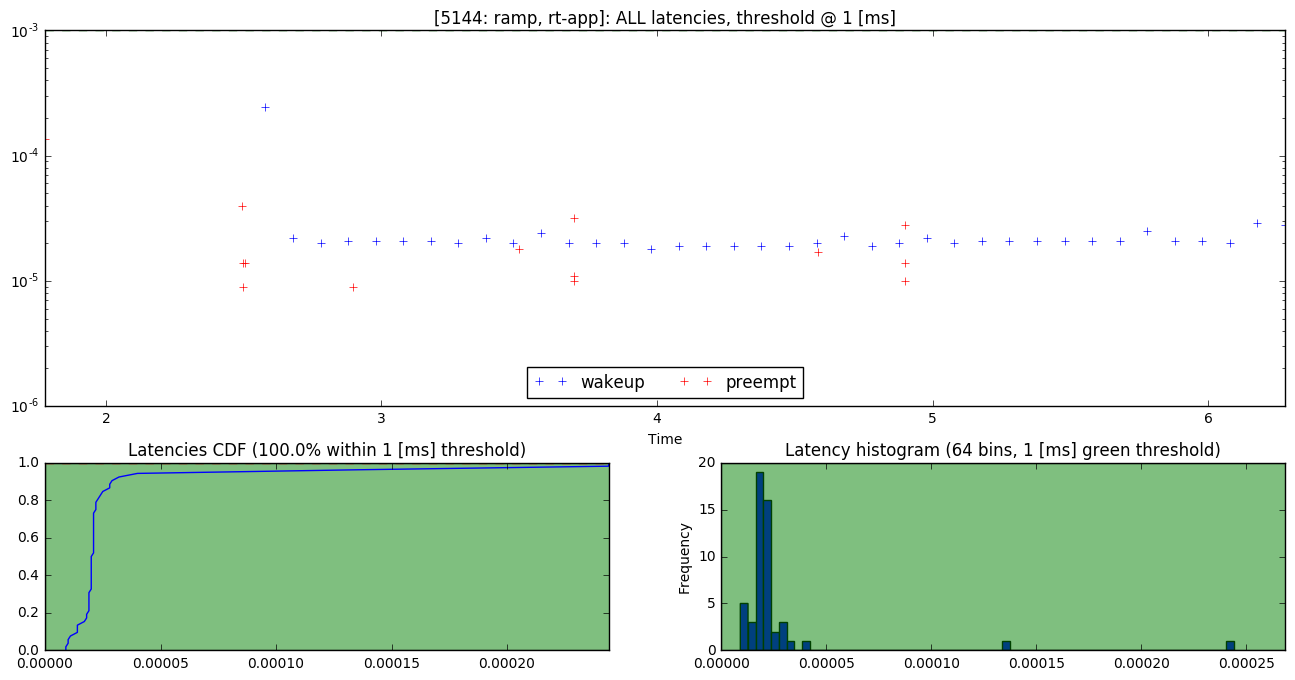

In [19]:
# Plot latency events for a specified task
latency_stats_df = trace.analysis.latency.plotLatency('ramp')

In [20]:
# Plot statistics on task latencies
latency_stats_df.T

,count,mean,std,min,50%,95%,99%,max,100.0%
latency,52.0,0.000027,0.000035,0.000009,0.00002,0.000036,0.000188,0.000244,0.001


In [21]:
print trace.analysis.latency.plotLatencyBands.__doc__


        Draw a plot that shows intervals of time when the execution of a
        RUNNABLE task has been delayed. The plot reports:
          WAKEUP     lantecies as RED colored bands
          PREEMPTION lantecies as BLUE colored bands

        The optional axes parameter allows to plot the signal on an existing
        graph.

        :param task: the task to report latencies for
        :type task: str

        :param axes: axes on which to plot the signal
        :type axes: :mod:`matplotlib.axes.Axes`
        


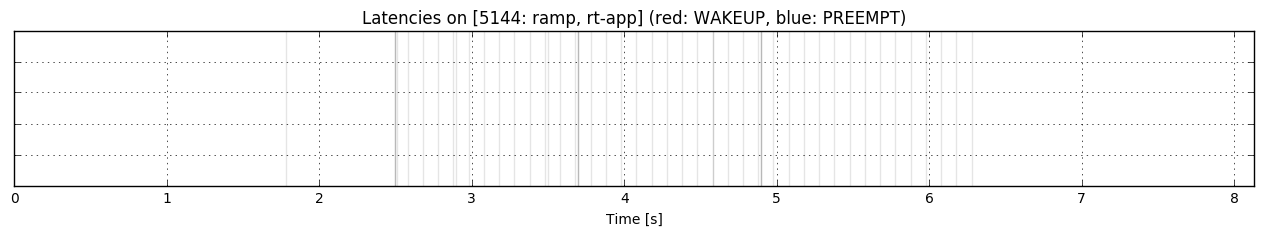

In [22]:
# Plot latency events for a specified task
trace.analysis.latency.plotLatencyBands('ramp')

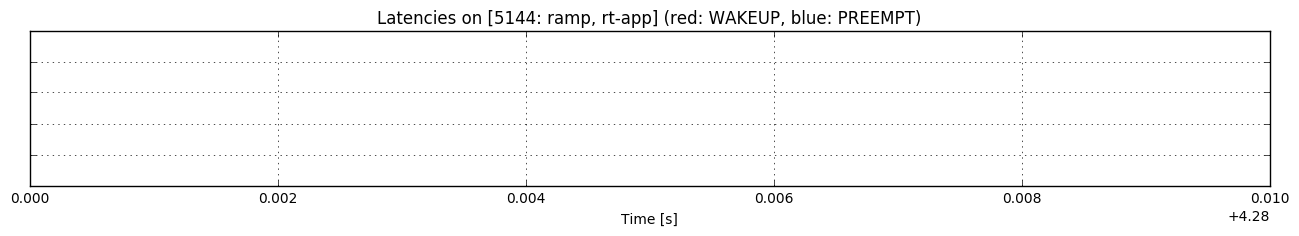

In [23]:
# Zoom into a spefific time frame
trace.setXTimeRange(4.28,4.29)
trace.analysis.latency.plotLatencyBands('ramp')

# Activations Analysis

## Activations DataFrames

In [24]:
print trace.data_frame.activations_df.__doc__


        DataFrame of task's wakeup intrvals

        The returned DataFrame has these columns:
        - Time: the wakeup time for the task
        - activation_interval: the time since the previous wakeup events

        :param task: the task to report runtimes for
        :type task: int or str
        


In [25]:
# Report the sequence of activations intervals:
# Time:                 wakeup time
# activation_internal:  time interval wrt previous wakeup
trace.data_frame.activations_df('ramp').head()

,activation_interval
Time,
2.578911,0.099997
2.678908,0.099999
2.778907,0.100000
2.878907,0.099996
2.978903,0.100001


## Activations Plots

In [26]:
print trace.analysis.latency.plotActivations.__doc__


        Plots "activation intervals" for the specified task

        An "activation interval" is time incurring between two consecutive
        wakeups of a task. A set of plots is generated to report:
        - Activations interval at wakeup time: every time a task wakeups a
          point is plotted to represent the time interval since the previous
          wakeup.
        - Activations interval cumulative function: reports the cumulative
          function of the activation intervals.
        - Activations interval histogram: reports a 64 bins histogram of
          the activation iternals.

        All plots are parameterized based on the value of threshold_ms, which
        can be used to filter activations intervals bigger than 2 times this
        value.
        Such a threshold is useful to filter out from the plots outliers thus
        focusing the analysis in the most critical periodicity under analysis.
        The number and percentage of discarded samples is reported i

2017-02-17 19:52:03,201 INFO    : Analysis     : Found:    38 activations for [5144: ramp, rt-app]
2017-02-17 19:52:03,203 WARNING : Analysis     : Discarding 1 activation intervals (above 2 x threshold_ms, 2.6% of the overall activations)
2017-02-17 19:52:03,205 INFO    : Analysis     : 100.0 % samples below 120 [ms] threshold
2017-02-17 19:52:03,258 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!


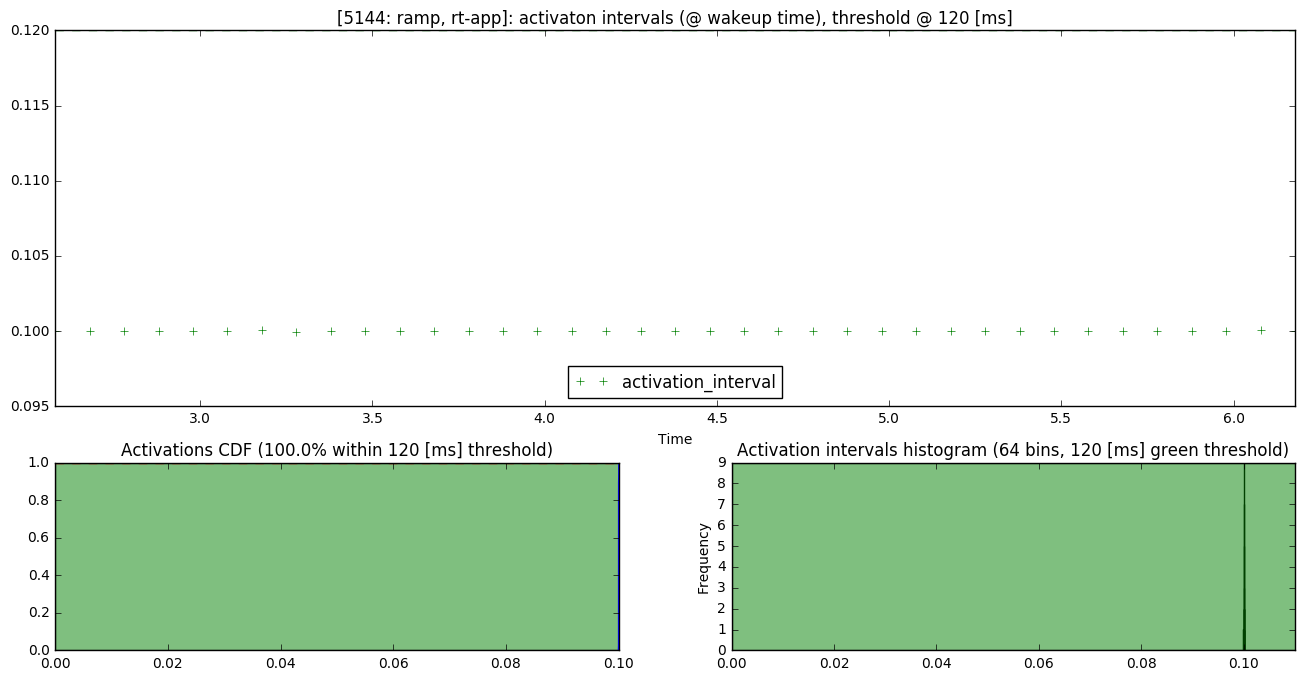

In [27]:
# Plot activation internvals for a specified task
activations_df = trace.analysis.latency.plotActivations('ramp', threshold_ms=120)

In [28]:
# Plot statistics on task activation intervals
activations_df.T

,count,mean,std,min,50%,95%,99%,max,100.0%
activation_interval,37.0,0.100002,0.000012,0.099966,0.1,0.100028,0.100039,0.10004,0.12


# Runtimes Analysis

## Runtimes DataFrames

In [29]:
print trace.data_frame.runtimes_df.__doc__


        DataFrame of task's runtime each time the task blocks

        The returned DataFrame has these columns:
        - Time: the time the task completed an activation (i.e. sleep or exit)
        - running_time: the time the task spent RUNNING since its last wakeup

        :param task: the task to report runtimes for
        :type task: int or str
        


In [30]:
# Report the sequence of running times:
# Time:          task block time (i.e. sleep or exit)
# running_time:  cumulative ruinning times since last wakeup event
trace.data_frame.runtimes_df('ramp').head()

,running_time
Time,
2.506287,0.790959
2.579155,0.059508
2.678930,0.059534
2.778927,0.054048
2.898286,0.054230


## Runtimes Plots

In [31]:
print trace.analysis.latency.plotRuntimes.__doc__


        Plots "running times" for the specified task

        A "running time" is the sum of all the time intervals a task executed
        in between a wakeup and the next sleep (or exit).
        A set of plots is generated to report:
        - Running times at block time: every time a task blocks a
          point is plotted to represent the cumulative time the task has be
          running since its last wakeup
        - Running time cumulative function: reports the cumulative
          function of the running times.
        - Running times histogram: reports a 64 bins histogram of
          the running times.

        All plots are parameterized based on the value of threshold_ms, which
        can be used to filter running times bigger than 2 times this value.
        Such a threshold is useful to filter out from the plots outliers thus
        focusing the analysis in the most critical periodicity under analysis.
        The number and percentage of discarded samples is reporte

2017-02-17 19:52:04,119 INFO    : Analysis     : Found:    39 activations for [5144: ramp, rt-app]
2017-02-17 19:52:04,121 WARNING : Analysis     : Discarding 1 running times (above 2 x threshold_ms, 2.6% of the overall activations)
2017-02-17 19:52:04,123 INFO    : Analysis     : 100.0 % samples below 120 [ms] threshold
2017-02-17 19:52:04,172 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!


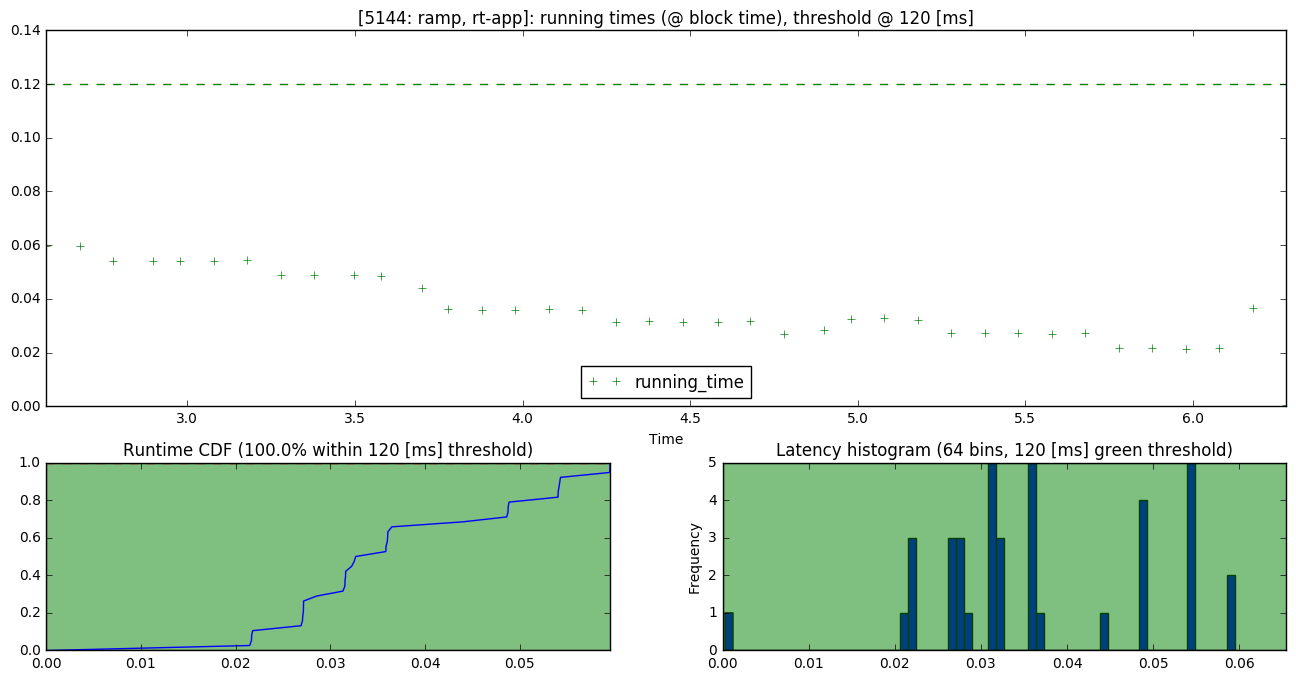

In [32]:
# Plot activation internvals for a specified task
runtimes_df = trace.analysis.latency.plotRuntimes('ramp', threshold_ms=120)

In [33]:
# Plot statistics on task running times
runtimes_df.T

,count,mean,std,min,50%,95%,99%,max,100.0%
running_time,38.0,0.036271,0.012981,0.000277,0.0326,0.055088,0.059524,0.059534,0.12
